# Imports and prep

In [4]:
!apt remove python3-xlrd
!apt remove python-xlrd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package 'python3-xlrd' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package 'python-xlrd' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [5]:
!pip uninstall xlrd
!pip install xlrd==1.2.0

Found existing installation: xlrd 1.1.0
Uninstalling xlrd-1.1.0:
  Would remove:
    /usr/local/bin/runxlrd.py
    /usr/local/lib/python3.7/dist-packages/xlrd-1.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xlrd/*
Proceed (y/n)? y
  Successfully uninstalled xlrd-1.1.0
     |████████████████████████████████| 103 kB 4.5 MB/s 


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime
import time
import re
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Input, Activation
from keras.callbacks import EarlyStopping

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# pump_data = '/content/gdrive/MyDrive/project/pump-data.zip'
# !unzip $pump_data -d /content 

In [8]:
!git clone https://github.com/paragdhankhart1dm/t1dmProject
!7z e t1dmProject/pump-data.zip -o/content/

Cloning into 't1dmProject'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 251847 bytes (246 KiB)

Extracting archive: t1dmProject/pump-data.zip
--
Path = t1dmProject/pump-data.zip
Type = zip
Physical Size = 251847

  0%    
Would you like to replace the existing file:
  Path:     /content/._MIL_014_medtronic.csv
  Size:     212 bytes (1 KiB)
  Modified: 2022-01-21 09:30:42
with the file from archive:
  Path:     __MACOSX/._MIL_014_medtronic.csv
  Size:     212 bytes (1 KiB)
  Modified: 2022-01-21 09:30:42
? (Y)es / (N)o 

In [9]:
files = os.listdir('/content/')
removes = []
for x in range(0,len(files)):
  if('mil' not in files[x]):
    removes.append(files[x])
    continue
  print(x+1 - len(removes),files[x])

for f in removes:
  files.remove(f)

print('--------------------------')
selected_file = files[int(input("Select a file: "))-1]
print(selected_file,'was selected')


1 mil_007_omnipod.xls
2 mil_016_omnipod.xls
3 ._mil_016_omnipod.xls
4 ._mil_028_omnipod.xls
5 ._mil_024_omnipod.xls
6 mil_028_omnipod.xls
7 ._mil_010_omnipod.xls
8 mil_010_omnipod.xls
9 mil_002_roche.xls
10 ._mil_007_omnipod.xls
11 ._mil_002_roche.xls
12 mil_021_omnipod.xls
13 ._mil_021_omnipod.xls
14 mil_024_omnipod.xls
--------------------------
Select a file: 8
mil_010_omnipod.xls was selected


In [10]:
#========================================================================================
#Write result of experiment in a file

def write_file(file_name, write_mode, write_string):
    '''
    Input: Output file name, Write mode, Write string
    Output: Writes result to the output file
    '''
    output_file = open(file_name, write_mode)
    output_file.write(write_string)
    output_file.write('\n\n')
    output_file.write('-------------------------------------------------------------------------')
    output_file.write('\n\n')
    output_file.close()

test_file_name = selected_file+"-training-test.txt"
# #Write output in a result file
# write_string = f'Experiment number: {experiment} \nTest case: {testcase} \nModel used: {model_name}'
# test_file_name = f'{experiment}_{testcase}_{model_name}_{patient}_{current_datetime}.txt'
# write_file( test_file_name, 'w', write_string)

# write_string = f'Experiment Done at Google Collab \nTime of Experiment: {current_datetime} (GMT) \nProcessor for model training: CPU'
# write_file( test_file_name, 'a', write_string)

# write_string = f'Input Variables: \nPatient: {patient} \ntraining_date: {training_date} \ntesting_date: {testing_date} \nbg_unit: {bg_unit}'
# write_string = write_string + f'\ninput_features: {input_features} \nhistory_points: {history_points} (12 history_points/hour) \nbatch_size: {batch_size}'
# write_string = write_string + f'\nlearning_rate: {learning_rate} \nValidation_split: {validation_split}'
# write_string = write_string + f'\nprediction_horizon: {prediction_horizon} ({prediction_horizon*5} minutes)'
# write_file( test_file_name, 'a', write_string)

# Clean and organize

In [11]:
insulin_sheet = "Insulin use and carbs"
bg_sheet = "Name and glucose"
insulin_data = pd.read_excel(selected_file,sheet_name=insulin_sheet)
bg_data = pd.read_excel(selected_file,sheet_name=bg_sheet,skiprows=4)
print('Insulin data')
print(insulin_data.head())
print(insulin_data.info())
print("\n\nBlood glucose data")
print(bg_data.head())
print(bg_data.info())

Insulin data
               Time  Basal Amount (U/h) Bolus Type  Bolus Volume (U)  \
0  25/02/2019 00:00                1.10        NaN               NaN   
1  25/02/2019 06:00                1.20        NaN               NaN   
2  25/02/2019 09:36                 NaN     Normal               1.9   
3  25/02/2019 10:00                1.05        NaN               NaN   
4  25/02/2019 11:41                0.00        NaN               NaN   

   Immediate Volume (U)  Extended Volume (U)  Duration (min)  Carbs(g)  Notes  \
0                   NaN                  NaN             NaN       NaN    NaN   
1                   NaN                  NaN             NaN       NaN    NaN   
2                   NaN                  NaN             NaN       NaN    NaN   
3                   NaN                  NaN             NaN       NaN    NaN   
4                   NaN                  NaN             NaN       NaN    NaN   

   Total daily dose  Total daily basal  Serial number  
0          

In [12]:
training_month = 'Feb2019' #Give training data month here - refer actual file name for this
# training_date = ['2019-08-16 00:00:00', '2019-08-17 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
training_date = ['2019-02-25 00:00:00', '2019-03-25 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
testing_month = 'Feb2019' #Give testing data month here - refer actual file name for this
# testing_date = ['2019-08-18 00:00:00', '2019-08-18 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
testing_date = ['2019-02-27 00:00:00', '2019-02-27 23:59:59'] #Format - YYYY-MM-DD HH24:MI:SS
bg_unit = 'mmol/L' #or Glucose Value (mmol/L)
input_features = [bg_unit, 'Basal', 'Bolus', 'Carbs_gm']

In [13]:
filtered_idata = insulin_data.copy()
filtered_idata['DateTime'] = pd.to_datetime(filtered_idata['Time'],utc=True)
dropped_features_insulin = ['Time','Notes','Serial number','Total daily dose','Total daily basal']
filtered_idata.drop(dropped_features_insulin,1,inplace=True)
filtered_idata.set_index('DateTime',inplace=True)
filtered_idata['Bolus Volume (U)'].fillna(0,inplace=True)
filtered_idata['Basal Amount (U/h)'].fillna(0,inplace=True)
filtered_idata['Carbs(g)'].fillna(0,inplace=True)
print(filtered_idata.info())

filtered_bgdata = bg_data.copy()
filtered_bgdata['DateTime'] = pd.to_datetime(filtered_bgdata['Time'],utc=True)
dropped_features_bg = ['Unnamed: 2','Serial number','Time']
filtered_bgdata.drop(dropped_features_bg,1,inplace=True)
filtered_bgdata.set_index('DateTime',inplace=True)
print('\n\n',filtered_bgdata.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 893 entries, 2019-02-25 00:00:00+00:00 to 2019-04-17 14:36:00+00:00
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Basal Amount (U/h)    893 non-null    float64
 1   Bolus Type            263 non-null    object 
 2   Bolus Volume (U)      893 non-null    float64
 3   Immediate Volume (U)  0 non-null      float64
 4   Extended Volume (U)   0 non-null      float64
 5   Duration (min)        0 non-null      float64
 6   Carbs(g)              893 non-null    float64
dtypes: float64(6), object(1)
memory usage: 55.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58 entries, 2019-02-25 09:36:00+00:00 to 2019-04-17 08:33:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mmol/L  58 non-null     float64
dtypes: float64(1)
memory usage: 928.0 bytes


 None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# Some random manual tests

In [14]:
# print(filtered_bgdata)
print(filtered_bgdata.index.name)
print(filtered_idata)
# filtered_idata.loc[(filtered_idata['Bolus Volume (U)']>0)]
# filtered_idata.loc[(filtered_idata['Basal Amount (U/h)']>0),'Basal Amount (U/h)']
filtered_idata.loc[(filtered_idata['Carbs(g)']>0),'Carbs(g)']

DateTime
                           Basal Amount (U/h) Bolus Type  Bolus Volume (U)  \
DateTime                                                                     
2019-02-25 00:00:00+00:00                1.10        NaN               0.0   
2019-02-25 06:00:00+00:00                1.20        NaN               0.0   
2019-02-25 09:36:00+00:00                0.00     Normal               1.9   
2019-02-25 10:00:00+00:00                1.05        NaN               0.0   
2019-02-25 11:41:00+00:00                0.00        NaN               0.0   
...                                       ...        ...               ...   
2019-04-17 12:15:00+00:00                0.00        NaN               0.0   
2019-04-17 12:15:00+00:00                0.00     Normal               3.8   
2019-04-17 13:40:00+00:00                0.00        NaN               0.0   
2019-04-17 13:40:00+00:00                0.00     Normal               7.0   
2019-04-17 14:36:00+00:00                0.00        Na

DateTime
2019-02-25 13:24:00+00:00    58.0
2019-02-25 15:03:00+00:00    15.0
2019-02-25 15:05:00+00:00    33.0
2019-02-25 17:26:00+00:00    18.0
2019-02-26 13:22:00+00:00    26.0
                             ... 
2019-04-16 21:16:00+00:00    73.0
2019-04-17 08:34:00+00:00    53.0
2019-04-17 12:15:00+00:00    41.0
2019-04-17 13:40:00+00:00    45.0
2019-04-17 14:36:00+00:00    26.0
Name: Carbs(g), Length: 222, dtype: float64

# Visualise

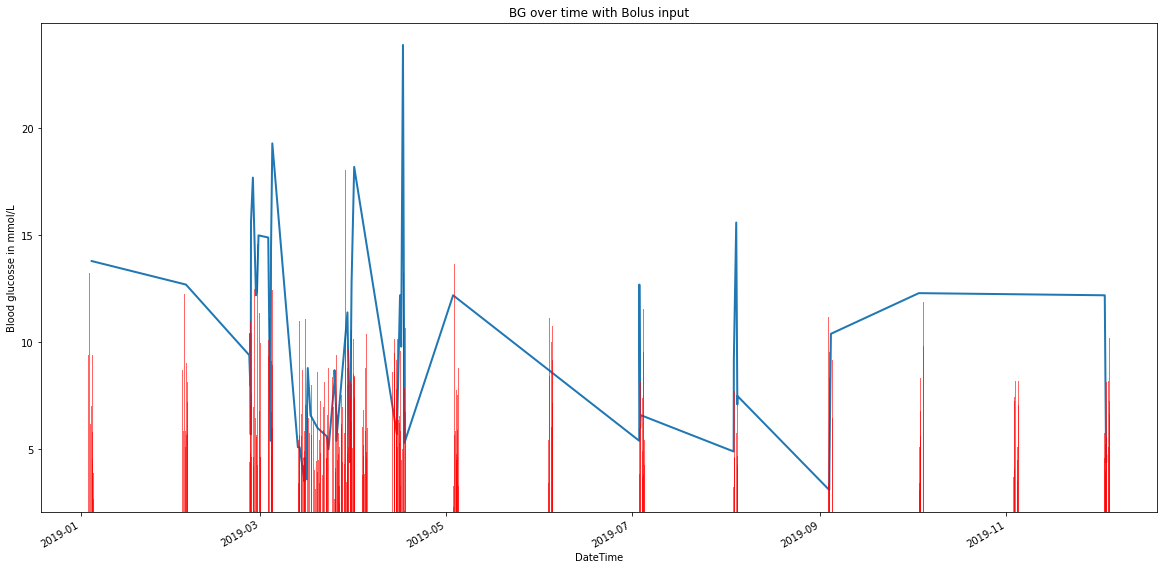

In [15]:
#graph
graph1 = filtered_bgdata['mmol/L'].plot.line(figsize=(20,10),title="BG over time with Bolus input",lw=2,)
graph1.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

#bolus intake
max = filtered_idata['Bolus Volume (U)'].max()
for y in filtered_idata.loc[(filtered_idata['Bolus Volume (U)']>0)].index:
  # print(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus Volume (U)']>0),'Bolus Volume (U)'].sum())
  bolus = float(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus Volume (U)']>0),'Bolus Volume (U)'].sum())
  ymax = bolus*0.7/max
  graph1.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff000099',lw=1) #remember, transparency at the end



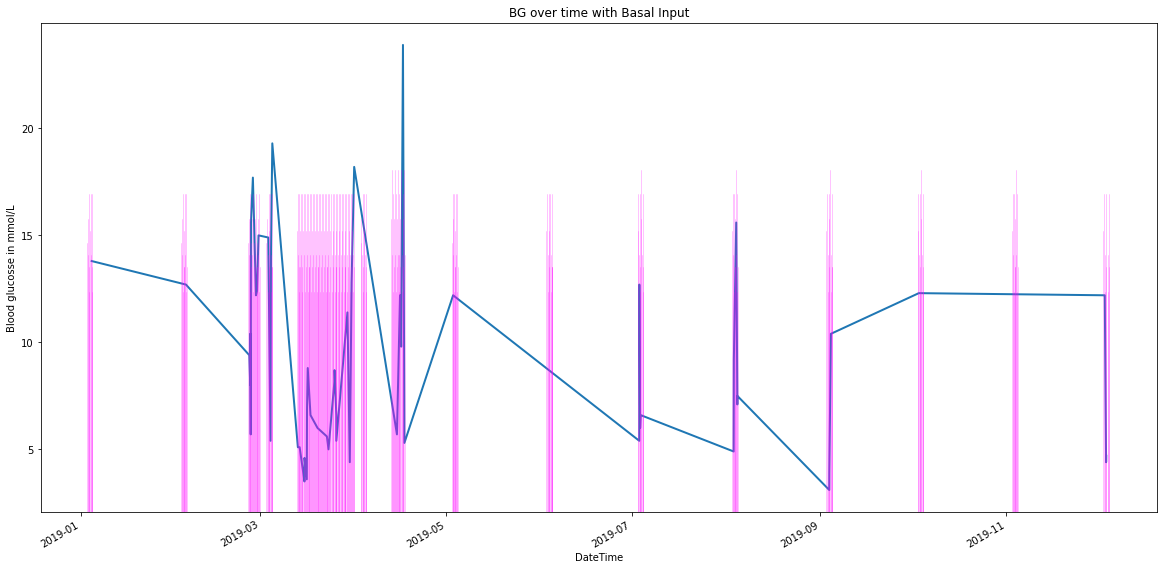

In [16]:
graph2 = filtered_bgdata['mmol/L'].plot.line(figsize=(20,10),title="BG over time with Basal Input",lw=2,)
graph2.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

max = filtered_idata['Basal Amount (U/h)'].max()
for y in filtered_idata.loc[(filtered_idata['Basal Amount (U/h)']>0),:].index:
  basal = float(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Basal Amount (U/h)']>0),'Basal Amount (U/h)'].sum())
  ymax = basal*0.7/max
  graph2.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff00ff77',lw=0.5) #remember, transparency at the end


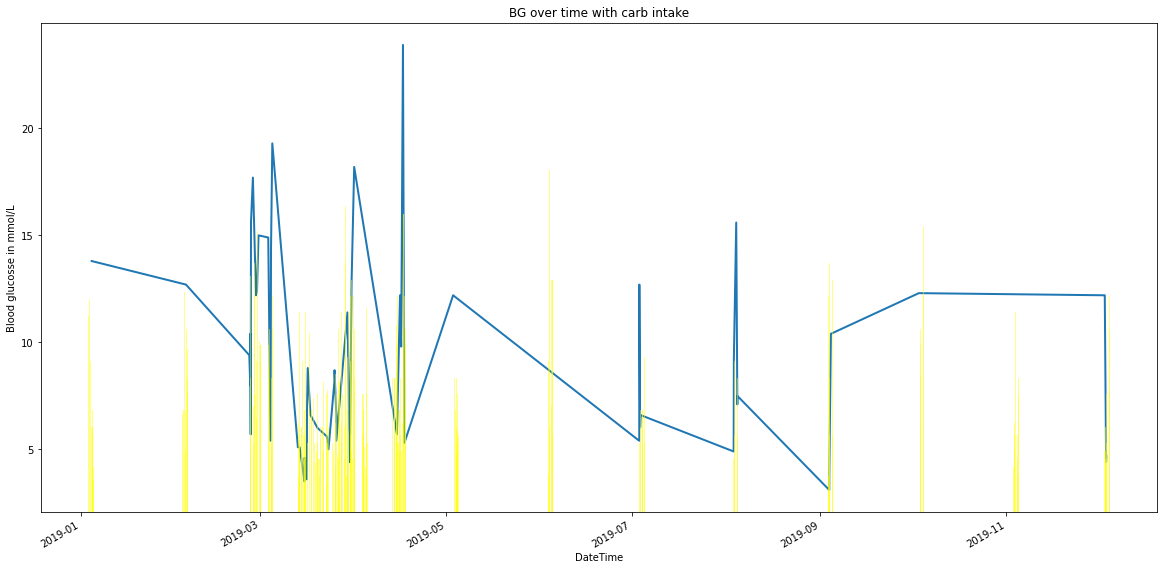

In [17]:
graph3 = filtered_bgdata['mmol/L'].plot.line(figsize=(20,10),title="BG over time with carb intake",lw=2,)
graph3.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

max = filtered_idata['Carbs(g)'].max()
for y in filtered_idata.loc[(filtered_idata['Carbs(g)']>0),:].index:
  carbs = float(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Carbs(g)']>0),'Carbs(g)'].sum())
  ymax = carbs*0.7/max
  graph3.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ffff0077',lw=1) #remember, transparency at the end


# Train

## Config

In [18]:
#Model's Input
history_points = 72 #Number of history records needed to predict future BG value
batch_size=50 #Batch size of LSTM model execution
learning_rate=0.01 #Learning rate of LSTM model
validation_split=0.2 #validation data during training
prediction_horizon=6 #BG Prediction horizon: Value 1 = 5 minutes PH; Value 2 = 10 minutes PH; Value 6 = 30 minutes PH

## Create a training dataset

In [19]:
basal = 'basal'
bolus = 'bolus'
carbs = 'carbs'
bg = 'bg'
rename_legend= {
  'Basal Amount (U/h)':basal,
  'Bolus Volume (U)':bolus,
  'Carbs(g)':carbs, 
  'mmol/L':bg
}


In [20]:
train_data = filtered_idata.copy()
dropped_features = ['Bolus Type','Immediate Volume (U)','Extended Volume (U)', 'Duration (min)']
train_data.drop(dropped_features,1,inplace=True)
temp_bg = filtered_bgdata.copy()
# do a manual join
train_data['mmol/L'] = 0.0
print(len(train_data),'rows in training data')
for index, row in temp_bg.iterrows():
  # print(row[bg_unit],row.index)
  l = train_data.loc[(train_data.index == index),bg_unit]
  if len(l)>0:
    train_data.loc[(train_data.index == index),bg_unit] = row[bg_unit]
  else:
    #insert a row
    # print('inserting new row')
    bg2 = row[bg_unit]
    train_data = train_data.append(pd.Series({
        'Basal Amount (U/h)':0.0, 
        'Bolus Volume (U)':0.0, 
        'Carbs(g)':0.0, 
        bg_unit: bg2
    }, name = index))
    # train_data = pd.concat([train_data,df_new])

#rename columns
train_data.rename(rename_legend,axis=1,inplace=True)
train_data = train_data[ (train_data.index >= training_date[0]) & (train_data.index <= training_date[1]) ]
print(train_data.columns,'columns in training data')
print(len(train_data),'Data points in training data')
print(train_data)
print(train_data.info())

#Problem: The model is not working properly when intermittent glucose levels are not monitored.
# So we're setting them to the level last monitored
train_data.sort_index(axis = 0,inplace=True)
last_non_zero = 0.0
# for index,row in train_data.iterrows():
#   if(row[bg] <= 0):
#     row[bg] = last_non_zero
#   if(row[bg]>0):
#     last_non_zero = row[bg]
train_data[bg].replace(0.0,np.nan,inplace=True)
train_data[bg].interpolate(method='time',limit_direction ='forward',inplace=True)
train_data[bg].fillna(0,inplace=True)
train_data.to_csv('train-test1.csv')

893 rows in training data
Index(['basal', 'bolus', 'carbs', 'bg'], dtype='object') columns in training data
314 Data points in training data
                           basal  bolus  carbs    bg
DateTime                                            
2019-02-25 00:00:00+00:00   1.10    0.0    0.0   0.0
2019-02-25 06:00:00+00:00   1.20    0.0    0.0   0.0
2019-02-25 09:36:00+00:00   0.00    1.9    0.0   9.4
2019-02-25 10:00:00+00:00   1.05    0.0    0.0   0.0
2019-02-25 11:41:00+00:00   0.00    0.0    0.0   0.0
...                          ...    ...    ...   ...
2019-03-17 12:07:00+00:00   0.00    0.0    0.0   6.6
2019-03-25 09:34:00+00:00   0.00    0.0    0.0   8.7
2019-03-25 23:46:00+00:00   0.00    0.0    0.0   6.6
2019-03-25 23:47:00+00:00   0.00    0.0    0.0   5.4
2019-03-04 23:04:00+00:00   0.00    0.0    0.0  19.3

[314 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2019-02-25 00:00:00+00:00 to 2019-03-04 23:04:00+00:00
Data columns (total 4 col

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


## Visualise training data

bg


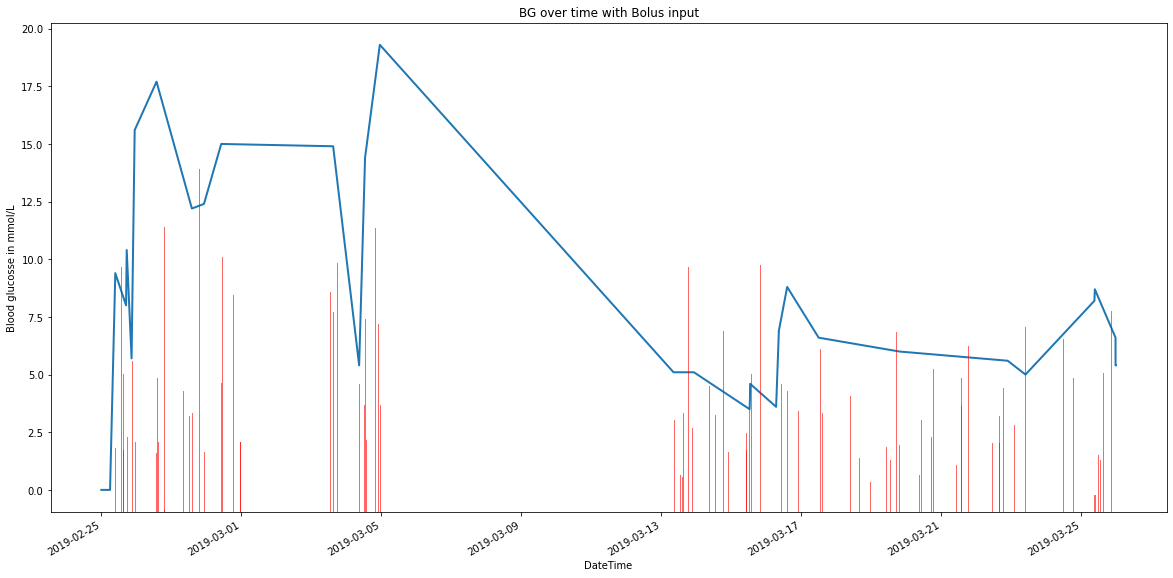

In [21]:
print(bg)
graph1 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with Bolus input",lw=2,)
graph1.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

#bolus intake
max = train_data[bolus].max()
for y in train_data.loc[(train_data[bolus]>0)].index:
  # print(filtered_idata.loc[(filtered_idata.index==y) & (filtered_idata['Bolus Volume (U)']>0),'Bolus Volume (U)'].sum())
  bolu = float(train_data.loc[(train_data.index==y) & (train_data[bolus]>0),bolus].sum())
  ymax = bolu*0.7/max
  graph1.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff000099',lw=1) #remember, transparency at the end


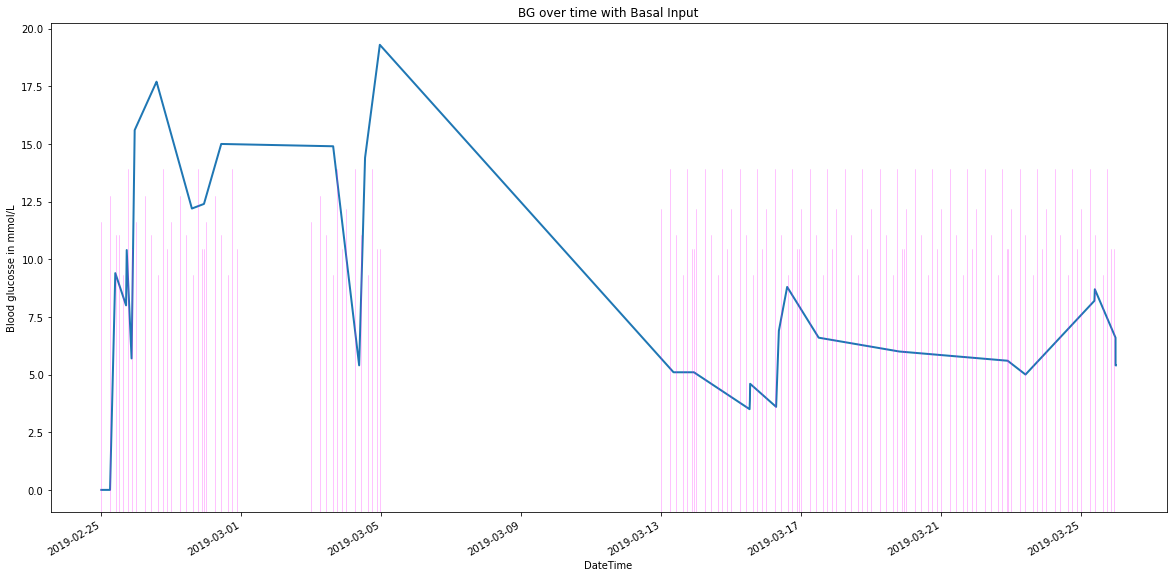

In [22]:
graph2 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with Basal Input",lw=2,)
graph2.set(xlabel="DateTime",ylabel='Blood glucosse in mmol/L')

max = train_data[basal].max()
for y in train_data.loc[(train_data[basal]>0),:].index:
  basa = float(train_data.loc[(train_data.index==y) & (train_data[basal]>0),basal].sum())
  ymax = basa*0.7/max
  graph2.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ff00ff77',lw=0.5) #remember, transparency at the end


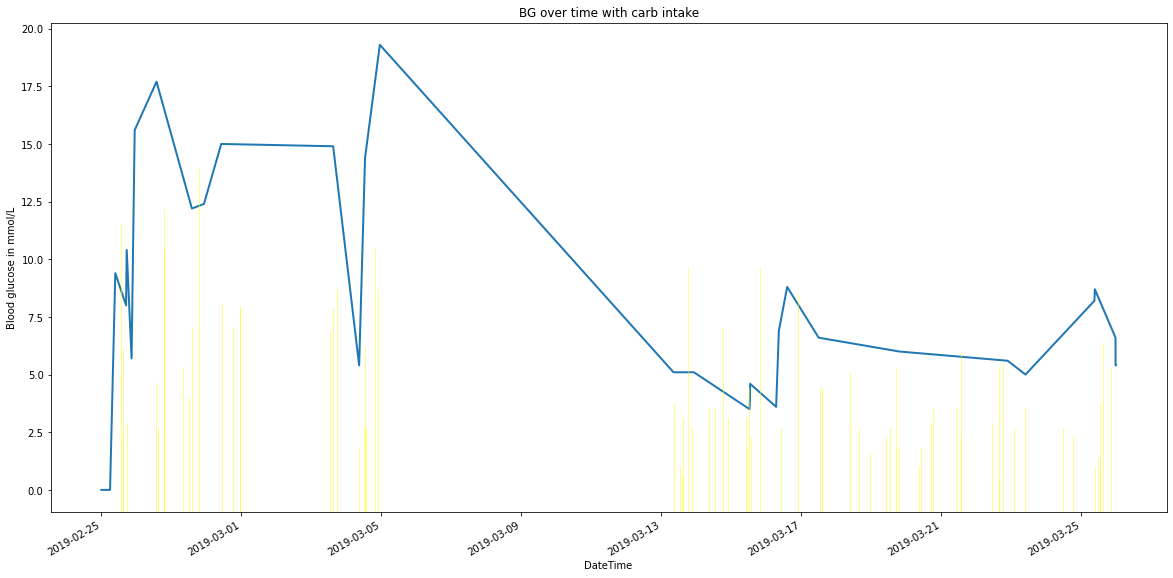

In [23]:
graph3 = train_data[bg].plot.line(figsize=(20,10),title="BG over time with carb intake",lw=2,)
graph3.set(xlabel="DateTime",ylabel='Blood glucose in mmol/L')

max = train_data[carbs].max()
for y in train_data.loc[(train_data[carbs]>0),:].index:
  carb = float(train_data.loc[(train_data.index==y) & (train_data[carbs]>0),carbs].sum())
  ymax = carb*0.7/max
  graph3.axvline(x=y,  ymin = 0.0, ymax = ymax, color='#ffff0077',lw=1) #remember, transparency at the end

## Prepare for training

In [24]:
normaliser = MinMaxScaler()
train_normalised_data = normaliser.fit_transform(train_data)

#For Denormalizing predicted BG data later
train_data_y = pd.DataFrame(train_data[bg])
scaler = MinMaxScaler()
scaler.fit_transform(train_data_y)

print(f'train_normalised_data_shape:{train_normalised_data.shape} \n', train_normalised_data)


train_normalised_data_shape:(314, 4) 
 [[0.84615385 0.         0.         0.        ]
 [0.92307692 0.         0.         0.        ]
 [0.         0.18627451 0.         0.48704663]
 ...
 [0.         0.         0.         0.34196891]
 [0.         0.         0.         0.27979275]
 [0.         0.         0.         0.27979275]]


In [25]:
#=========================================================================
#Preparing rows of data as a 3D-array of history points
#History points is the number of records needed to predict a future value

X_train = np.array([train_normalised_data[i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

print(f'X_train_shape:{X_train.shape} \n')
print(f'y_train_shape: {y_train.shape} \n')

X_train_shape:(242, 72, 4) 

y_train_shape: (242,) 



# Model

## Design

In [ ]:
tf.random.set_seed(20)
np.random.seed(10)

#input shape of the model
input_features = [bg,basal,bolus,carbs]
print(input_features)
input_shape=(history_points, len(input_features))

lstm_input = Input(shape=input_shape, name='lstm_input') #input layer
inputs = Dropout(0.5, name='dropout_0')(lstm_input)
inputs = LSTM(50, return_sequences=True, name='lstm_1')(inputs)
inputs = Dropout(0.5, name='dropout_1')(inputs)
inputs = LSTM(50, return_sequences=True, name='lstm_2')(inputs)
inputs = Dropout(0.5, name='dropout_2')(inputs)
inputs = LSTM(50, name='lstm_3')(inputs) #Note: return_sequences=True not given here
inputs = Dropout(0.5, name='dropout_3')(inputs)
inputs = Dense(prediction_horizon, name='dense_layer')(inputs) #output layer
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)

#Model optimizer
adam = tf.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer=adam, loss='mse')

#Model Summary
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

#Write output in a result file
write_string = short_model_summary
write_file( test_file_name, 'a', write_string)

['bg', 'basal', 'bolus', 'carbs']
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 72, 4)]           0         
                                                                 
 dropout_0 (Dropout)         (None, 72, 4)             0         
                                                                 
 lstm_1 (LSTM)               (None, 72, 50)            11000     
                                                                 
 dropout_1 (Dropout)         (None, 72, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 72, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 72, 50)            0         
                                                                 
 lstm_3 (LSTM)             

## Train

In [ ]:
#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 

#Training and validation of data
start_time = time.time()
model_training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=1000, callbacks=[es], validation_split = validation_split, shuffle=True)
elapsed_time = time.time() - start_time
n_epochs = len(model_training.history['loss'])
print('Training time: ', round(elapsed_time,2))


#Write output in a result file
write_string = f'Early stopping monitor: val_loss \nValidation split: {validation_split} \nNumber of epochs: {n_epochs} \nTraining time: {round(elapsed_time,2)} sec'
write_file( test_file_name, 'a', write_string)

Epoch 1/1000
4/4 [==============================] - 9s 727ms/step - loss: 0.2416 - val_loss: 0.2115
Epoch 2/1000
4/4 [==============================] - 1s 147ms/step - loss: 0.2037 - val_loss: 0.1895
Epoch 3/1000
4/4 [==============================] - 1s 155ms/step - loss: 0.1866 - val_loss: 0.1824
Epoch 4/1000
4/4 [==============================] - 1s 150ms/step - loss: 0.1920 - val_loss: 0.1808
Epoch 5/1000
4/4 [==============================] - 1s 149ms/step - loss: 0.1843 - val_loss: 0.1875
Epoch 6/1000
4/4 [==============================] - 1s 145ms/step - loss: 0.1932 - val_loss: 0.1863
Epoch 7/1000
4/4 [==============================] - 1s 144ms/step - loss: 0.1898 - val_loss: 0.1813
Epoch 8/1000
4/4 [==============================] - 1s 141ms/step - loss: 0.1883 - val_loss: 0.1838
Epoch 9/1000
4/4 [==============================] - 1s 144ms/step - loss: 0.1825 - val_loss: 0.1883
Epoch 10/1000
4/4 [==============================] - 1s 143ms/step - loss: 0.1831 - val_loss: 0.1857

## Check fit

method : {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’}

In [ ]:
#=========================================================================
#Checking predictions of training data
#y-pred will return values equal to n-PH ahead
y_pred = model.predict(X_train)
y_pred = scaler.inverse_transform(y_pred)

#Getting the output equal to PH in a 2D array of 1 column
if prediction_horizon != 1:
    y_pred = y_pred[:,prediction_horizon-1]
    y_pred = np.reshape(y_pred, ((len(train_data)-history_points), 1))

y_pred.shape

#=========================================================================
#Predicted vs Actual value in training
#Adjusting y-pred data points consistent withactual y-values
train_result = train_data.iloc[history_points+prediction_horizon-1:]
train_result.rename(columns={bg: 'Actual Glucose Value (mmol/L)'}, inplace=True)
train_result['Predicted Glucose Value (mmol/L)'] = y_pred[:len(train_result),:] #Picking the first n predictions matching it with available actual value
train_result = train_result[['Actual Glucose Value (mmol/L)', 'Predicted Glucose Value (mmol/L)']] #Getting only Actual and Predicted values on mg/dl
# train_result['Actual Glucose Value (mmol/L)'] = train_result['Actual Glucose Value (mmol/L)'] / 18
# train_result['Predicted Glucose Value (mmol/L)'] = train_result['Predicted Glucose Value (mmol/L)'] / 18
train_result

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Actual Glucose Value (mmol/L),Predicted Glucose Value (mmol/L)
DateTime,,
2019-03-03 15:00:00+00:00,14.900065,5.655848
2019-03-03 15:03:00+00:00,14.900000,5.600042
2019-03-03 15:03:00+00:00,14.900000,5.453803
2019-03-03 17:59:00+00:00,13.337383,5.264017
2019-03-03 17:59:00+00:00,13.337383,5.169683
...,...,...
2019-03-25 22:57:00+00:00,6.720775,5.677653
2019-03-25 22:59:00+00:00,6.715845,5.694311
2019-03-25 23:46:00+00:00,6.600000,5.615758


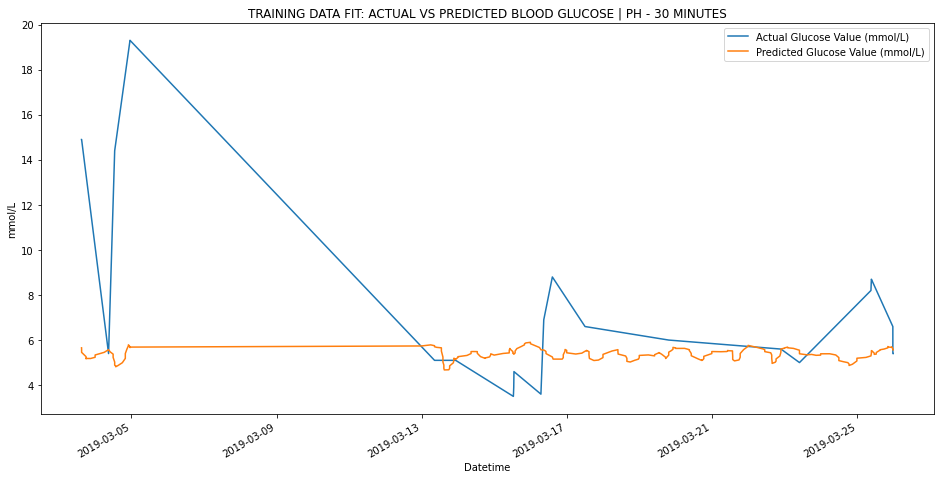

In [ ]:
#=========================================================================
#Graph plot of training data fit
title = 'TRAINING DATA FIT: ACTUAL VS PREDICTED BLOOD GLUCOSE' + ' | ' + 'PH - ' + str(prediction_horizon*5) + ' MINUTES'
graph=train_result.plot.line(y=['Actual Glucose Value (mmol/L)', 'Predicted Glucose Value (mmol/L)'],figsize=(16,8),title=title)
graph.set(xlabel='Datetime',ylabel=bg_unit);